# Diffusion Model on MNIST (From Scratch)

In this notebook, we build a **Diffusion Model (DDPM)** from scratch using PyTorch.

### Goals
- Understand the **Forward Diffusion Process** (adding noise)
- Build a **U-Net** to predict noise
- Train the model to learn noise prediction
- Generate new handwritten digits using **Reverse Diffusion**

---


In [ ]:
import math
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)


Device: cuda


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.53MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.80MB/s]


## 1) Preview Real Data

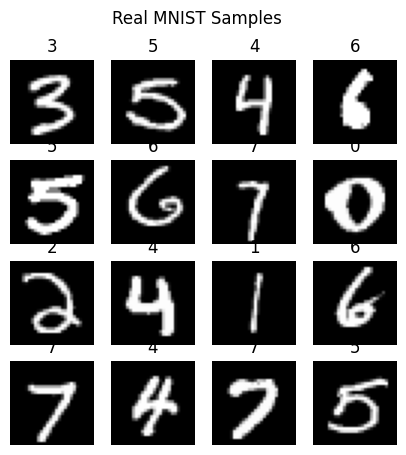

In [ ]:
x_preview, y_preview = next(iter(train_loader))

plt.figure(figsize=(5,5))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(x_preview[i][0], cmap="gray")
    plt.title(int(y_preview[i]))
    plt.axis("off")
plt.suptitle("Real MNIST Samples")
plt.show()


## 2) Diffusion Noise Schedule (β, α, ᾱ)

In [ ]:
T = 500

def make_beta_schedule(T, beta_start=1e-4, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, T)  #Linear Beta Schedule

# β_t increases gradually from beta_start to beta_end
betas = make_beta_schedule(T).to(device)

# α_t = 1 - β_t (how much signal remains each step)
alphas = (1.0 - betas).to(device)

# ᾱ_t = Π_{i=1..t} α_i (cumulative product)
alpha_bars = torch.cumprod(alphas, dim=0).to(device)



def print_schedule_samples(betas, alphas, alpha_bars, steps=[0, 50, 100, 200]):
    print(" t |    beta    |   alpha   | alpha_bar")
    print("----------------------------------------")
    for t in steps:
        print(f"{t:3d} | {betas[t]:.6f} | {alphas[t]:.6f} | {alpha_bars[t]:.6f}")

print_schedule_samples(betas, alphas, alpha_bars)



 t |    beta    |   alpha   | alpha_bar
----------------------------------------
  0 | 0.000100 | 0.999900 | 0.999900
 50 | 0.002094 | 0.997906 | 0.945552
100 | 0.004088 | 0.995912 | 0.809140
200 | 0.008076 | 0.991924 | 0.438713


## What does each term represent?

- **beta (βₜ)**  
  The amount of **new noise added** at timestep `t`.

- **alpha (αₜ = 1 − βₜ)**  
  The amount of **signal preserved** at timestep `t`.

- **alpha_bar (ᾱₜ)**  
  The **total remaining fraction of the original image** after `t` steps.

---

## 3) Forward Diffusion Function

In [ ]:
def q_sample(x0, t, eps):
    """
    x0: original image [B, 1, 28, 28]
    t: timesteps [B] (each sample may have a different t)
    eps: gaussian noise [B, 1, 28, 28]
    x_t = sqrt(alpha_bar_t)*x0 + sqrt(1-alpha_bar_t)*eps
    returns: x_t based on the closed-form equation.
    """
    # alpha_bars[t] gives ᾱ_t for each sample
    a_bar = alpha_bars[t].view(-1,1,1,1)
    # sqrt(ᾱ_t) * x0
    signal = torch.sqrt(a_bar) * x0

    # sqrt(1 - ᾱ_t) * eps
    noise = torch.sqrt(1.0 - a_bar) * eps

    return signal + noise

## 4) Visualize Forward Diffusion

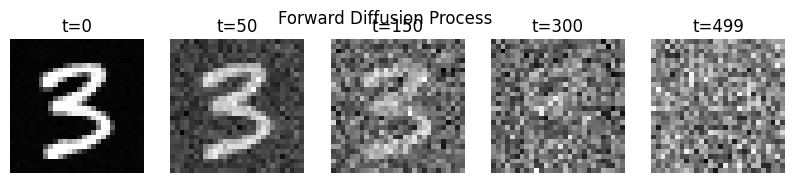

In [ ]:
with torch.no_grad():
    img = x_preview[0:1].to(device)
    steps = [0, 50, 150, 300, T-1]

    plt.figure(figsize=(10,2))
    for i, step in enumerate(steps):
        t = torch.tensor([step], device=device)
        eps = torch.randn_like(img)
        xt = q_sample(img, t, eps)
        plt.subplot(1,len(steps),i+1)
        plt.imshow(xt[0,0].cpu(), cmap="gray")
        plt.title(f"t={step}")
        plt.axis("off")

    plt.suptitle("Forward Diffusion Process")
    plt.show()

## 5) Time Embedding

In [ ]:
def sinusoidal_time_embedding(timesteps, dim):
  """
t: [B] timesteps (long)
returns: [B, dim] time embeddings
"""
    half = dim // 2
    freqs = torch.exp(
        -math.log(10000) * torch.arange(0, half, device=timesteps.device).float() / half
    )
    args = timesteps.float().unsqueeze(1) * freqs.unsqueeze(0)
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=1)
    return emb


## 6) Residual Block

In [ ]:
# Tensor shape convention in this model:
# B  = Batch size       (number of images processed together)
# ch = Channels         (number of feature maps)
# H  = Height           (image or feature map height)
# W  = Width            (image or feature map width)

# Example:
# x shape = [128, 64, 28, 28]
# Means:
# 128 images in the batch
# 64 feature channels per image
# Each feature map size = 28 × 28 pixels


In [ ]:
# Residual Block:
# Takes noisy feature maps + time embedding
# Injects timestep information into channels
# Uses skip connection for stable and deep training
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim):
        super().__init__()

        # First convolution:
        # Takes input feature maps and produces new feature maps
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)

        # Second convolution:
        # Further refines the featuresout_ch
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)

        # Time embedding projection:
        # Converts the time embedding vector into channel-sized vector
        # so we can inject timestep information into the feature maps [B, ch, H, W]
        self.time_proj = nn.Linear(time_dim, )

        # Skip connection:
        # If input and output channels are different,
        # use a 1x1 convolution to match dimensions.
        # Otherwise, use identity (pass input as-is).
        self.skip = nn.Conv2d(in_ch, out_ch, kernel_size=1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        # x: input feature maps [B, in_ch, H, W]
        # t_emb: time embedding vector [B, time_dim]

        # First conv + activation
        h = F.silu(self.conv1(x))

        # Project time embedding to match channel dimension
        # ثم نضيفه لكل pixels عبر broadcasting
        time_added = self.time_proj(t_emb).view(-1, h.size(1), 1, 1)
        h = h + time_added

        # Second conv + activation
        h = F.silu(self.conv2(h))

        # Residual connection:
        # Add the original input (possibly projected) to the output
        # This helps stable training and better gradient flow
        return h + self.skip(x)

## 7) Down & Up Blocks

In [ ]:
class Down(nn.Module):
    def __init__(self, ch):
        super().__init__()
        # Downsampling convolution:
        # Reduces spatial size (H,W) by factor of 2
        # Keeps the same number of channels
        self.down = nn.Conv2d(ch, ch, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        # x: input feature maps [B, ch, H, W]
        # Output: [B, ch, H/2, W/2]
        return self.down(x)


class Up(nn.Module):
    def __init__(self, ch):
        super().__init__()

        # Upsampling transposed convolution:
        # Increases spatial size (H,W) by factor of 2
        # Keeps the same number of channels
        self.up = nn.ConvTranspose2d(ch, ch, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        # x: input feature maps [B, ch, H, W]
        # Output: [B, ch, H*2, W*2]
        return self.up(x)


## 8) Build U-Net

In [ ]:
# U-Net for Diffusion:
# Takes noisy image + timestep embedding
# Encoder compresses features
# Bottleneck processes global information
# Decoder reconstructs features using skip connections
# Outputs predicted noise ε̂

class UNet(nn.Module):
    def __init__(self, in_ch=1, base=128, time_dim=128, num_classes=None):
        super().__init__()

        # time_dim: length of time embedding vector
        # base: base number of channels in the network
        self.time_dim = time_dim
        self.num_classes = num_classes

        # ------------------------------------------------
        # (Optional) Label Embedding for Conditional Diffusion
        # If num_classes is given, we embed labels and add them to time embedding
        # ------------------------------------------------
        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)

        # ------------------------------------------------
        # Time Embedding MLP
        # Takes sinusoidal time embedding and refines it
        # ------------------------------------------------
        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, time_dim * 4),
            nn.SiLU(),
            nn.Linear(time_dim * 4, time_dim)
        )

        # ------------------------------------------------
        # Input Convolution
        # Converts input image into base feature channels
        # ------------------------------------------------
        self.in_conv = nn.Conv2d(in_ch, base, kernel_size=3, padding=1)

        # ------------------------------------------------
        # Encoder (Downsampling Path)
        # ------------------------------------------------
        self.rb1 = ResBlock(base, base, time_dim)
        self.down1 = Down(base)

        self.rb2 = ResBlock(base, base * 2, time_dim)
        self.down2 = Down(base * 2)

        self.rb3 = ResBlock(base * 2, base * 2, time_dim)

        # ------------------------------------------------
        # Bottleneck (Middle of U-Net)
        # ------------------------------------------------
        self.mid1 = ResBlock(base * 2, base * 4, time_dim)
        self.mid2 = ResBlock(base * 4, base * 4, time_dim)
        self.mid3 = ResBlock(base * 4, base * 2, time_dim)

        # ------------------------------------------------
        # Decoder (Upsampling Path)
        # ------------------------------------------------
        self.up1 = Up(base * 2)
        self.rb4 = ResBlock(base * 4, base * 2, time_dim)

        self.up2 = Up(base * 2)
        self.rb5 = ResBlock(base * 3, base, time_dim)

        # ------------------------------------------------
        # Output Layers
        # ------------------------------------------------
        self.out_norm = nn.GroupNorm(8, base)
        self.out_conv = nn.Conv2d(base, 1, kernel_size=3, padding=1)

    def forward(self, x, t, y=None):
        # ------------------------------------------------
        # x: Noisy image        [B, 1, H, W]
        # t: Timestep indices  [B]
        # y: (Optional) class labels for conditional generation
        # ------------------------------------------------

        # Create sinusoidal time embedding
        t_emb = sinusoidal_time_embedding(t, self.time_dim)

        # Refine time embedding through MLP
        t_emb = self.time_mlp(t_emb)

        # If conditional, add label embedding
        if self.num_classes is not None:
            t_emb = t_emb + self.label_emb(y)

        # ------------------------------------------------
        # Encoder Path (store skip connections)
        # ------------------------------------------------
        x1 = self.rb1(self.in_conv(x), t_emb)     # First block
        x2 = self.rb2(self.down1(x1), t_emb)      # Down + block
        x3 = self.rb3(self.down2(x2), t_emb)      # Down + block

        # ------------------------------------------------
        # Bottleneck
        # ------------------------------------------------
        h = self.mid1(x3, t_emb)
        h = self.mid2(h, t_emb)
        h = self.mid3(h, t_emb)

        # ------------------------------------------------
        # Decoder Path (use skip connections)
        # ------------------------------------------------
        h = self.up1(h)
        h = self.rb4(torch.cat([h, x2], dim=1), t_emb)

        h = self.up2(h)
        h = self.rb5(torch.cat([h, x1], dim=1), t_emb)

        # ------------------------------------------------
        # Output predicted noise ε̂
        # ------------------------------------------------
        return self.out_conv(F.silu(self.out_norm(h)))


# Summary Before Training

## U-Net Ready

We now have a U-Net that:
- Receives a **noisy image xₜ**
- Receives a **time embedding t**
- Outputs **predicted noise ε̂**

Next step: **Train the model to predict noise**


# Training the Noise Predictor (U-Net)

Now that we have:
- The forward diffusion process
- The noise schedule
- The U-Net architecture

We will **train the U-Net** to predict the noise ε inside a noisy image xₜ.

### Training Objective

Given:
- Noisy image xₜ
- Timestep t
- True noise ε

The U-Net learns:

ε̂ = U-Net(xₜ, t)

Loss = MSE(ε̂ , ε)

After training, the U-Net becomes a **noise predictor**.


## Logging Setup

In [ ]:
import time
import csv
from datetime import datetime

RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")
LOG_DIR = "./logs"
os.makedirs(LOG_DIR, exist_ok=True)

CSV_PATH = os.path.join(LOG_DIR, f"mnist_diffusion_{RUN_ID}.csv")
TXT_PATH = os.path.join(LOG_DIR, f"mnist_diffusion_{RUN_ID}.txt")

def log_print(msg):
    print(msg)
    with open(TXT_PATH, "a") as f:
        f.write(msg + "\n")

# CSV Header
with open(CSV_PATH, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["type","epoch","step","t_min","t_max","loss","lr","time_sec","note"])


## 1) Model & Optimizer Setup

In [ ]:
# ------------------------------------------------
# Model & Optimizer Setup
# ------------------------------------------------

# If True → model learns to generate specific digits (conditional diffusion)
use_conditional = True

# Build the U-Net model
# in_ch = 1 (grayscale MNIST)
# base = 128 (base feature channels)
# time_dim = 128 (time embedding size)
# num_classes = 10 (digits 0 → 9) if conditional
model = UNet(
    in_ch=1,
    base=128,
    time_dim=128,
    num_classes=(10 if use_conditional else None)
).to(device)

# AdamW optimizer (commonly used in diffusion models)
opt = optim.AdamW(model.parameters(), lr=2e-4)

# Mean Squared Error loss:
# Model learns to predict the true noise
loss_fn = nn.MSELoss()

# Number of training epochs
epochs = 15

# Store loss history for plotting
loss_hist = []

## Training Loop (Core Learning Step)

In [ ]:
# ------------------------------------------------
# Training Loop
# ------------------------------------------------
# Training Step Summary:
# 1) Pick random timestep t
# 2) Add noise to real image → x_t
# 3) U-Net predicts the noise ε̂
# 4) Compute MSE loss(ε̂ , ε)
# 5) Update model weights

model.train()
global_step = 0

for ep in range(1, epochs + 1):
    epoch_losses = []
    t0 = time.time()

    for i, (x0, y) in enumerate(train_loader, start=1):

        # Move real images and labels to GPU
        x0 = x0.to(device)
        y = y.to(device)

        # 1) Sample random timesteps for each image in the batch
        # t shape = [B]
        t = torch.randint(0, T, (x0.size(0),), device=device)

        # 2) Sample Gaussian noise ε
        eps = torch.randn_like(x0)

        # 3) Create noisy image x_t using forward diffusion equation
        xt = q_sample(x0, t, eps)

        # 4) Predict noise using the U-Net
        if use_conditional:
            eps_pred = model(xt, t, y=y)
        else:
            eps_pred = model(xt, t)

        # 5) Compute loss between predicted noise and true noise
        loss = loss_fn(eps_pred, eps)

        # 6) Backpropagation and parameter update
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store loss values
        loss_hist.append(loss.item())
        epoch_losses.append(loss.item())

    # Print average loss per epoch
    print(f"Epoch {ep} | Avg Loss: {sum(epoch_losses)/len(epoch_losses):.4f}")


Epoch 1 | Avg Loss: 0.0884
Epoch 2 | Avg Loss: 0.0415
Epoch 3 | Avg Loss: 0.0373
Epoch 4 | Avg Loss: 0.0353
Epoch 5 | Avg Loss: 0.0341
Epoch 6 | Avg Loss: 0.0336
Epoch 7 | Avg Loss: 0.0328
Epoch 8 | Avg Loss: 0.0325
Epoch 9 | Avg Loss: 0.0321
Epoch 10 | Avg Loss: 0.0319
Epoch 11 | Avg Loss: 0.0314
Epoch 12 | Avg Loss: 0.0312
Epoch 13 | Avg Loss: 0.0312
Epoch 14 | Avg Loss: 0.0307
Epoch 15 | Avg Loss: 0.0307


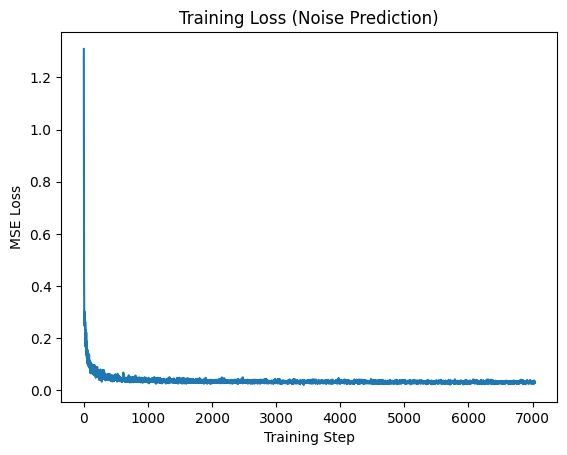

In [ ]:
plt.plot(loss_hist)
plt.title("Training Loss (Noise Prediction)")
plt.xlabel("Training Step")
plt.ylabel("MSE Loss")
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ===============================
# Save Trained Model
# ===============================
MODEL_PATH = "/content/drive/MyDrive/diffusion_unet_mnist.pth"

torch.save(model.state_dict(), MODEL_PATH)

print("✅ Model saved to Google Drive at:")
print(MODEL_PATH)


✅ Model saved to Google Drive at:
/content/drive/MyDrive/diffusion_unet_mnist.pth


# 🎨 Reverse Diffusion (Image Generation)

After training, the U-Net can now remove noise step-by-step.

We start from **pure noise**, and repeatedly apply the reverse diffusion equation:

xₜ → xₜ₋₁ → ... → x₀ (generated image)

This is how new digits are generated.


# Reverse Step Function

In [ ]:
@torch.no_grad()
def p_sample(x, t, y=None):
    """
    One reverse diffusion step:
    Converts x_t → x_{t-1}
    """

    # Predict the noise inside the current noisy image
    eps_pred = model(x, t, y=y)

    # Get diffusion schedule values at timestep t
    beta_t = betas[t[0]]
    alpha_t = alphas[t[0]]
    alpha_bar_t = alpha_bars[t[0]]

    # ---------------------------------------------------
    # Compute the mean of the reverse process
    # This equation removes part of the predicted noise
    # ---------------------------------------------------
    mean = (1.0 / torch.sqrt(alpha_t)) * (
        x - (beta_t / torch.sqrt(1.0 - alpha_bar_t)) * eps_pred
    )

    # ---------------------------------------------------
    # Add random noise except at the final step (t = 0)
    # ---------------------------------------------------
    if t[0] > 0:
        z = torch.randn_like(x)              # fresh Gaussian noise
        return mean + torch.sqrt(beta_t) * z # x_{t-1}
    else:
        return mean                           # final clean image x_0


# Load Diffusion_unet_mnist Model  from Google Drive and ready!

In [ ]:
import math
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [ ]:
MODEL_PATH = "/content/drive/MyDrive/diffusion_unet_mnist.pth"

model = UNet(in_ch=1, base=128, time_dim=128, num_classes=10).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
print("✅ Model loaded from Google Drive and ready!")


✅ Model loaded from Google Drive and ready!


## Full Sampling Loop

In [ ]:
# Reverse Diffusion:
# Start from random noise
# Repeat T reverse steps
# Each step removes predicted noise
# Final output = generated clean image

@torch.no_grad()
def sample(n=16, y=None):
    # Set model to evaluation mode
    # This disables training-specific behaviors
    # and ensures stable image generation
    model.eval()

    # ---------------------------------------------------
    # Start from pure random noise
    # ---------------------------------------------------
    x = torch.randn(n, 1, 28, 28, device=device)

    # ---------------------------------------------------
    # Reverse diffusion: step-by-step denoising
    # from t = T-1 down to t = 0
    # ---------------------------------------------------
    for t_inv in range(T - 1, -1, -1):
        t = torch.full((n,), t_inv, device=device, dtype=torch.long)
        x = p_sample(x, t, y=y)

    # Final generated images
    return x


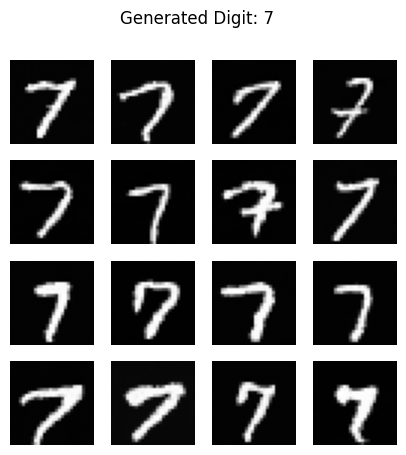

In [ ]:
target_digit = 7
y = torch.full((16,), target_digit, device=device, dtype=torch.long)

gen = sample(16, y=y)

plt.figure(figsize=(5,5))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(gen[i,0].cpu(), cmap="gray")
    plt.axis("off")

plt.suptitle(f"Generated Digit: {target_digit}")
plt.show()


# **[MNIST_Diffusion_Inference.ipynb link](https://colab.research.google.com/drive/1yh6UP46M0_q2Y0vs9zloquxTUSt3rZaO?usp=sharing)**